In [3]:
from dataclasses import dataclass
import json
from pathlib import Path
from typing import Dict, List, Set, Tuple
from collections import defaultdict

@dataclass
class ExperimentConfig:
    depths: List[int]
    hidden_sizes: List[int]
    train_sizes: List[int]
    learning_rates: List[float]

@dataclass
class ResultsData:
    nn_results: List[dict]
    ntk_results: List[dict]
    config: ExperimentConfig
    
    def filter_results(self, model_type: str, **kwargs) -> List[dict]:
        """
        Filter results based on given parameters.
        
        Args:
            model_type: Either 'nn' or 'ntk'
            **kwargs: Key-value pairs to filter on (e.g., depth=2, hidden_size=128)
            
        Returns:
            List of results matching the criteria
        """
        results = self.nn_results if model_type == 'nn' else self.ntk_results
        filtered = []
        
        for result in results:
            matches = True
            for key, value in kwargs.items():
                # Handle learning_rate/lr difference
                if key == 'learning_rate' and 'lr' in result:
                    if result['lr'] != value:
                        matches = False
                        break
                elif result.get(key) != value:
                    matches = False
                    break
            if matches:
                filtered.append(result)
                
        return filtered

class ResultsLoader:
    @staticmethod
    def _load_file(file_path: Path) -> List[dict]:
        """Load a single JSON file, handling empty files and errors."""
        try:
            with open(file_path) as f:
                content = f.read().strip()
                if not content:
                    print(f"Warning: Empty file found - {file_path}")
                    return []
                    
                results = json.loads(content)
                return results if isinstance(results, list) else [results]
                    
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            return []

    @staticmethod
    def _extract_config(nn_results: List[dict], ntk_results: List[dict]) -> ExperimentConfig:
        """Extract configuration parameters from results."""
        depths = sorted(set(r['depth'] for r in nn_results))
        hidden_sizes = sorted(set(r['hidden_size'] for r in nn_results))
        train_sizes = sorted(set(r['n_train'] for r in nn_results))
        
        # Handle different learning rate keys
        learning_rates = set()
        for r in nn_results:
            lr = r.get('learning_rate', r.get('lr'))
            if lr is not None:
                learning_rates.add(lr)
        
        return ExperimentConfig(
            depths=depths,
            hidden_sizes=hidden_sizes,
            train_sizes=train_sizes,
            learning_rates=sorted(learning_rates)
        )

    @staticmethod
    def _standardize_result(result: dict, model_type: str) -> dict:
        """Standardize a single result dictionary."""
        result = result.copy()
        
        # Standardize learning rate key
        if 'lr' in result and 'learning_rate' not in result:
            result['learning_rate'] = result['lr']
            del result['lr']
            
        # Add model type
        result['model_type'] = model_type
        
        return result

    @classmethod
    def load_results(cls, nn_results_dir: str, ntk_results_path: str) -> ResultsData:
        """
        Load and preprocess both NN and NTK results into a structured format.
        
        Args:
            nn_results_dir: Directory containing NN result JSON files
            ntk_results_path: Path to the NTK results JSON file
            
        Returns:
            ResultsData object containing preprocessed results and configuration
        """
        # Convert paths
        nn_dir = Path(nn_results_dir)
        ntk_path = Path(ntk_results_path)
        
        # Load NN results
        nn_files = list(nn_dir.glob("results*.json"))
        if not nn_files:
            raise ValueError(f"No result files found in {nn_results_dir}")
        
        nn_results = []
        for file_path in nn_files:
            results = cls._load_file(file_path)
            nn_results.extend(cls._standardize_result(r, 'nn') for r in results)
            
        # Load NTK results
        ntk_results = [
            cls._standardize_result(r, 'ntk') 
            for r in cls._load_file(ntk_path)
        ]
        
        print(f"Loaded {len(nn_results)} NN results and {len(ntk_results)} NTK results")
        
        # Extract configuration
        config = cls._extract_config(nn_results, ntk_results)
        
        # Sort results
        def sort_key(r):
            return (r['depth'], r['hidden_size'], r['n_train'])
            
        nn_results.sort(key=sort_key)
        ntk_results.sort(key=sort_key)
        
        return ResultsData(
            nn_results=nn_results,
            ntk_results=ntk_results,
            config=config
        )


def calculate_statistics(results: List[dict], group_by: str) -> Dict:
    """Calculate basic statistics for results grouped by a key."""
    stats = defaultdict(lambda: {'count': 0, 'sum': 0.0, 'sum_sq': 0.0})
    
    for result in results:
        group = result[group_by]
        error = result['test_error']
        
        stats[group]['count'] += 1
        stats[group]['sum'] += error
        stats[group]['sum_sq'] += error * error
    
    # Calculate mean and std
    formatted_stats = {}
    for group, values in stats.items():
        count = values['count']
        mean = values['sum'] / count
        variance = (values['sum_sq'] / count) - (mean * mean)
        std = variance ** 0.5 if variance > 0 else 0
        
        formatted_stats[group] = {
            'mean': mean,
            'std': std,
            'count': count
        }
    
    return formatted_stats

# Example usage:
def load_and_analyze_results(nn_dir: str, ntk_path: str) -> ResultsData:
    """Example function showing how to use the ResultsLoader."""
    # Load results
    results_data = ResultsLoader.load_results(nn_dir, ntk_path)
    
    # Print configuration summary
    print("\nExperiment Configuration:")
    print(f"Depths: {results_data.config.depths}")
    print(f"Hidden sizes: {results_data.config.hidden_sizes}")
    print(f"Training sizes: {results_data.config.train_sizes}")
    print(f"Learning rates: {results_data.config.learning_rates}")
    
    # Print some basic statistics
    print("\nNN Results Summary:")
    nn_stats = calculate_statistics(results_data.nn_results, 'depth')
    for depth, stats in sorted(nn_stats.items()):
        print(f"Depth {depth}:")
        print(f"  Mean: {stats['mean']:.4f}")
        print(f"  Std:  {stats['std']:.4f}")
        print(f"  Count: {stats['count']}")
    
    print("\nNTK Results Summary:")
    ntk_stats = calculate_statistics(results_data.ntk_results, 'depth')
    for depth, stats in sorted(ntk_stats.items()):
        print(f"Depth {depth}:")
        print(f"  Mean: {stats['mean']:.4f}")
        print(f"  Std:  {stats['std']:.4f}")
        print(f"  Count: {stats['count']}")
    
    return results_data

Loaded 866 NN results and 2346 NTK results


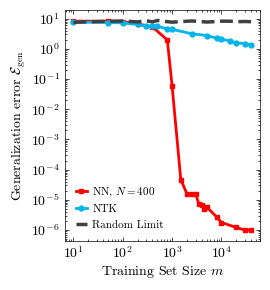

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
from typing import Dict, List, Optional, Tuple, Union
from dataclasses import dataclass
from pathlib import Path



@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None  # Custom label field

class SciencePlotter:
    # Define colors as class attributes
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#d1001d'
    greyblack = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        
        # Define default color schemes
        self.colors = {
            'purple': self.PURPLE,
            'blue': self.BLUE,
            'green': self.GREEN,
            'orange': self.ORANGE,
            'red': self.RED,
            'greyblack': self.greyblack
        }
    
    @staticmethod
    def setup_science_style():
        """Set up consistent science styling with proper log-scale ticks."""
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (3.3, 2.5),
            'figure.dpi': 100,
            
            # Font settings
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            
            # Axis settings
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            
            # Tick settings
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            
            # Grid settings
            'grid.linewidth': 0.5,
            
            # Line settings
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            
            # Legend settings
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def configure_log_axes(self, ax):
        """Configure axes for proper log scale appearance."""
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.minorticks_on()
        
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(mpl.ticker.LogFormatterSciNotation())
            axis.set_major_locator(mpl.ticker.LogLocator(numticks=15))
            axis.set_minor_locator(mpl.ticker.LogLocator(subs=np.arange(2, 10), numticks=15))
            axis.set_tick_params(which='both', direction='in')

    def plot_training_curves(self,
                           results_data: ResultsData,
                           nn_config: Dict[str, List],
                           kernel_config: Dict[str, List],
                           training_modes: List[str] = ['ntk'],
                           nn_styles: Optional[Dict[int, PlotStyle]] = None,
                           kernel_styles: Optional[Dict[str, Dict[int, PlotStyle]]] = None,
                           figsize: Optional[Tuple[float, float]] = None,
                           legend_loc: str = 'upper right',
                           legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
                           legend_fontsize: Optional[float] = None,
                           xlabel: Optional[str] = None,
                           ylabel: Optional[str] = None) -> plt.Figure:
        """
        Create training curves plot with customizable legend.
        
        Args:
            results_data: ResultsData object
            nn_config: Neural network configuration
            kernel_config: Kernel configuration for both NTK and NNGP
            training_modes: List of kernel training modes ('ntk', 'nngp', 'random_limit')
            nn_styles: Dict mapping widths to PlotStyle objects for NN curves
            kernel_styles: Dict mapping kernel types to width styles
            figsize: Optional figure size
            legend_loc: Location of the legend ('upper right', 'center left', etc.)
            legend_bbox_to_anchor: Tuple of (x, y) coordinates for legend position
            legend_fontsize: Font size for legend text
            xlabel: Custom x-axis label
            ylabel: Custom y-axis label
        """
        if figsize is None:
            figsize = (3.3, 2.5)
            
        fig, ax = plt.subplots(figsize=figsize)
        
        # Default style for neural networks
        default_nn_style = PlotStyle(
            color=self.colors['blue'], 
            linestyle='-', 
            linewidth=1.0,
            marker='o',
            markersize=3,
            label=None
        )
        
        # Plot NN results
        for depth in nn_config['depths']:
            for width in nn_config['widths']:
                style = nn_styles.get(width, default_nn_style) if nn_styles else default_nn_style
                
                for lr in nn_config['learning_rates']:
                    results = results_data.filter_results(
                        'nn', depth=depth, hidden_size=width, learning_rate=lr
                    )
                    if results:
                        sorted_results = sorted(results, key=lambda x: x['n_train'])
                        train_sizes = [r['n_train'] for r in sorted_results]
                        errors = [r['test_error'] for r in sorted_results]
                        
                        # Use custom label if provided, otherwise use default
                        label = style.label if style.label is not None else f'NN d={depth},h={width}'
                        
                        ax.plot(train_sizes, errors, 
                               color=style.color,
                               linestyle=style.linestyle,
                               linewidth=style.linewidth,
                               marker=style.marker,
                               markersize=style.markersize,
                               alpha=style.alpha,
                               label=label)
        
        # Plot kernel results (NTK, NNGP, and Random Limit)
        for mode in training_modes:
            # Set default style based on kernel type
            if mode == 'ntk':
                default_color = self.colors['purple']
                default_linestyle = '--'
            elif mode == 'nngp':
                default_color = self.colors['green']
                default_linestyle = ':'
            else:  # random_limit
                default_color = self.colors['orange']
                default_linestyle = '-.'
                
            default_kernel_style = PlotStyle(
                color=default_color,
                linestyle=default_linestyle,
                linewidth=1.0,
                marker='o',
                markersize=3,
                label=None
            )
            
            for depth in kernel_config['depths']:
                for width in kernel_config['widths']:
                    style = (kernel_styles.get(mode, {}).get(width, default_kernel_style) 
                            if kernel_styles else default_kernel_style)
                    
                    results = [r for r in results_data.filter_results('kernel', depth=depth, hidden_size=width)
                              if r.get('training_mode') == mode]
                    
                    if results:
                        sorted_results = sorted(results, key=lambda x: x['n_train'])
                        train_sizes = [r['n_train'] for r in sorted_results]
                        errors = [r['test_error'] for r in sorted_results]
                        
                        # Use custom label if provided, otherwise use default
                        kernel_type = {
                            'ntk': 'NTK',
                            'nngp': 'NNGP',
                            'random_limit': 'Random'
                        }.get(mode, mode.upper())
                        label = style.label if style.label is not None else f'{kernel_type} d={depth},h={width}'
                        
                        ax.plot(train_sizes, errors,
                               color=style.color,
                               linestyle=style.linestyle,
                               linewidth=style.linewidth,
                               marker=style.marker,
                               markersize=style.markersize,
                               alpha=style.alpha,
                               label=label)
        
        # Configure log axes
        self.configure_log_axes(ax)
        
        # Set labels
        ax.set_xlabel(xlabel if xlabel is not None else 'Training Size', labelpad=2)
        ax.set_ylabel(ylabel if ylabel is not None else 'Test Error', labelpad=2)
        
        # Add legend with customizable position and size
        legend_kwargs = {
            'frameon': False,
            'loc': legend_loc,
            'handlelength': 1.0,
            'handletextpad': 0.5
        }
        
        if legend_bbox_to_anchor is not None:
            legend_kwargs['bbox_to_anchor'] = legend_bbox_to_anchor
            
        if legend_fontsize is not None:
            legend_kwargs['fontsize'] = legend_fontsize
            
        ax.legend(**legend_kwargs)
        
        plt.tight_layout()
        return fig


def create_training_plot(
    results_data,
    nn_config: dict,
    kernel_config: dict,
    nn_styles: dict,
    kernel_styles: dict,
    training_modes: List[str] = ['ntk'],
    figsize: Optional[Tuple[float, float]] = None,
    legend_loc: str = 'upper right',
    legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
    legend_fontsize: Optional[float] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None
):
    """
    Create a training plot with specified configurations and styles.
    
    Args:
        results_data: The loaded results data
        nn_config: Configuration for neural networks
        kernel_config: Configuration for kernels (NTK/NNGP/Random)
        nn_styles: Dictionary mapping widths to PlotStyle objects for NN
        kernel_styles: Dictionary mapping kernel types to width styles
        training_modes: List of kernel modes to plot
        figsize: Optional figure size
        legend_loc: Location of the legend
        legend_bbox_to_anchor: Tuple of (x, y) coordinates for legend position
        legend_fontsize: Font size for legend text
        xlabel: Custom x-axis label
        ylabel: Custom y-axis label
    """
    plotter = SciencePlotter()
    
    # Create the plot
    fig = plotter.plot_training_curves(
        results_data,
        nn_config=nn_config,
        kernel_config=kernel_config,
        training_modes=training_modes,
        nn_styles=nn_styles,
        kernel_styles=kernel_styles,
        figsize=figsize,
        legend_loc=legend_loc,
        legend_bbox_to_anchor=legend_bbox_to_anchor,
        legend_fontsize=legend_fontsize,
        xlabel=xlabel,
        ylabel=ylabel
    )
    
    return fig

# Usage example:
plotter = SciencePlotter()

# Define styles for neural networks
nn_styles = {
   
    400: PlotStyle(
        color=plotter.RED,
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=3.0,
        label=r"NN, $N=400$"
    )
}

# Define styles for kernels (NTK, NNGP, and Random Limit)
kernel_styles = {
    'ntk': {
        8000: PlotStyle(
            color=plotter.BLUE,
            linestyle='-',
            linewidth=2.0,
            marker='o',
            markersize=3.5,
            label="NTK"
        )
    },
 
    'random_limit': {
       8000: PlotStyle(
           color=plotter.greyblack,
           linestyle='dashed',
           linewidth=2.5,
           marker='',
           markersize=2.5,
           label="Random Limit"
       )
    }
}

# Define configurations
nn_config = {
    'depths': [4],
    'widths': [400],
    'learning_rates': [0.05]
}

kernel_config = {
    'depths': [4],
    'widths': [8000]
}
nn_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_0701_mup_lr005"
ntk_path = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_1812_spectral/final_results_20241219_015151.json"
results_data = ResultsLoader.load_results(nn_dir, ntk_path)
# Create plot with all kernel types
fig = create_training_plot(
    results_data=results_data,
    nn_config=nn_config,
    kernel_config=kernel_config,
    nn_styles=nn_styles,
    kernel_styles=kernel_styles,
    training_modes=['ntk','random_limit'],  # Include all three kernel types ['ntk', 'nngp', 'random_limit']
    figsize=(2.8, 3.0), #3.8,2.7
    legend_loc='lower left',
    legend_fontsize=8,
    xlabel=r'Training Set Size $m$',
    ylabel=r'Generalization error $\mathcal{E}_{\mathrm{gen}}$'
)

# Save plot as both PNG and SVG
fig.savefig('training_curves.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white',
            edgecolor='black')

fig.savefig('training_curves.svg',
            bbox_inches='tight',
            facecolor='white',
            edgecolor='black')

Loaded 827 NN results and 2484 NTK results


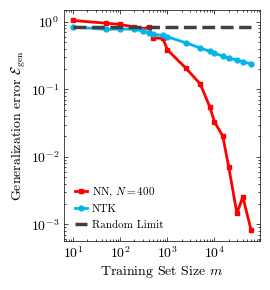

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
from typing import Dict, List, Optional, Tuple, Union
from dataclasses import dataclass
from pathlib import Path



@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None  # Custom label field

class SciencePlotter:
    # Define colors as class attributes
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    greyblack = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        
        # Define default color schemes
        self.colors = {
            'purple': self.PURPLE,
            'blue': self.BLUE,
            'green': self.GREEN,
            'orange': self.ORANGE,
            'red': self.RED,
            'greyblack': self.greyblack
        }
    
    @staticmethod
    def setup_science_style():
        """Set up consistent science styling with proper log-scale ticks."""
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (3.3, 2.5),
            'figure.dpi': 100,
            
            # Font settings
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            
            # Axis settings
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            
            # Tick settings
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            
            # Grid settings
            'grid.linewidth': 0.5,
            
            # Line settings
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            
            # Legend settings
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def configure_log_axes(self, ax):
        """Configure axes for proper log scale appearance."""
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.minorticks_on()
        
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(mpl.ticker.LogFormatterSciNotation())
            axis.set_major_locator(mpl.ticker.LogLocator(numticks=15))
            axis.set_minor_locator(mpl.ticker.LogLocator(subs=np.arange(2, 10), numticks=15))
            axis.set_tick_params(which='both', direction='in')

    def plot_training_curves(self,
                           results_data: ResultsData,
                           nn_config: Dict[str, List],
                           kernel_config: Dict[str, List],
                           training_modes: List[str] = ['ntk'],
                           nn_styles: Optional[Dict[int, PlotStyle]] = None,
                           kernel_styles: Optional[Dict[str, Dict[int, PlotStyle]]] = None,
                           figsize: Optional[Tuple[float, float]] = None,
                           legend_loc: str = 'upper right',
                           legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
                           legend_fontsize: Optional[float] = None,
                           xlabel: Optional[str] = None,
                           ylabel: Optional[str] = None) -> plt.Figure:
        """
        Create training curves plot with customizable legend.
        
        Args:
            results_data: ResultsData object
            nn_config: Neural network configuration
            kernel_config: Kernel configuration for both NTK and NNGP
            training_modes: List of kernel training modes ('ntk', 'nngp', 'random_limit')
            nn_styles: Dict mapping widths to PlotStyle objects for NN curves
            kernel_styles: Dict mapping kernel types to width styles
            figsize: Optional figure size
            legend_loc: Location of the legend ('upper right', 'center left', etc.)
            legend_bbox_to_anchor: Tuple of (x, y) coordinates for legend position
            legend_fontsize: Font size for legend text
            xlabel: Custom x-axis label
            ylabel: Custom y-axis label
        """
        if figsize is None:
            figsize = (3.3, 2.5)
            
        fig, ax = plt.subplots(figsize=figsize)
        
        # Default style for neural networks
        default_nn_style = PlotStyle(
            color=self.colors['blue'], 
            linestyle='-', 
            linewidth=1.0,
            marker='o',
            markersize=3,
            label=None
        )
        
        # Plot NN results
        for depth in nn_config['depths']:
            for width in nn_config['widths']:
                style = nn_styles.get(width, default_nn_style) if nn_styles else default_nn_style
                
                for lr in nn_config['learning_rates']:
                    results = results_data.filter_results(
                        'nn', depth=depth, hidden_size=width, learning_rate=lr
                    )
                    if results:
                        sorted_results = sorted(results, key=lambda x: x['n_train'])
                        train_sizes = [r['n_train'] for r in sorted_results]
                        errors = [r['test_error'] for r in sorted_results]
                        
                        # Use custom label if provided, otherwise use default
                        label = style.label if style.label is not None else f'NN d={depth},h={width}'
                        
                        ax.plot(train_sizes, errors, 
                               color=style.color,
                               linestyle=style.linestyle,
                               linewidth=style.linewidth,
                               marker=style.marker,
                               markersize=style.markersize,
                               alpha=style.alpha,
                               label=label)
        
        # Plot kernel results (NTK, NNGP, and Random Limit)
        for mode in training_modes:
            # Set default style based on kernel type
            if mode == 'ntk':
                default_color = self.colors['purple']
                default_linestyle = '--'
            elif mode == 'nngp':
                default_color = self.colors['green']
                default_linestyle = ':'
            else:  # random_limit
                default_color = self.colors['orange']
                default_linestyle = '-.'
                
            default_kernel_style = PlotStyle(
                color=default_color,
                linestyle=default_linestyle,
                linewidth=1.0,
                marker='o',
                markersize=3,
                label=None
            )
            
            for depth in kernel_config['depths']:
                for width in kernel_config['widths']:
                    style = (kernel_styles.get(mode, {}).get(width, default_kernel_style) 
                            if kernel_styles else default_kernel_style)
                    
                    results = [r for r in results_data.filter_results('kernel', depth=depth, hidden_size=width)
                              if r.get('training_mode') == mode]
                    
                    if results:
                        sorted_results = sorted(results, key=lambda x: x['n_train'])
                        train_sizes = [r['n_train'] for r in sorted_results]
                        errors = [r['test_error'] for r in sorted_results]
                        
                        # Use custom label if provided, otherwise use default
                        kernel_type = {
                            'ntk': 'NTK',
                            'nngp': 'NNGP',
                            'random_limit': 'Random'
                        }.get(mode, mode.upper())
                        label = style.label if style.label is not None else f'{kernel_type} d={depth},h={width}'
                        
                        ax.plot(train_sizes, errors,
                               color=style.color,
                               linestyle=style.linestyle,
                               linewidth=style.linewidth,
                               marker=style.marker,
                               markersize=style.markersize,
                               alpha=style.alpha,
                               label=label)
        
        # Configure log axes
        self.configure_log_axes(ax)
        
        # Set labels
        ax.set_xlabel(xlabel if xlabel is not None else 'Training Size', labelpad=2)
        ax.set_ylabel(ylabel if ylabel is not None else 'Test Error', labelpad=2)
        
        # Add legend with customizable position and size
        legend_kwargs = {
            'frameon': False,
            'loc': legend_loc,
            'handlelength': 1.0,
            'handletextpad': 0.5
        }
        
        if legend_bbox_to_anchor is not None:
            legend_kwargs['bbox_to_anchor'] = legend_bbox_to_anchor
            
        if legend_fontsize is not None:
            legend_kwargs['fontsize'] = legend_fontsize
            
        ax.legend(**legend_kwargs)
        
        plt.tight_layout()
        return fig


def create_training_plot(
    results_data,
    nn_config: dict,
    kernel_config: dict,
    nn_styles: dict,
    kernel_styles: dict,
    training_modes: List[str] = ['ntk'],
    figsize: Optional[Tuple[float, float]] = None,
    legend_loc: str = 'upper right',
    legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
    legend_fontsize: Optional[float] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None
):
    """
    Create a training plot with specified configurations and styles.
    
    Args:
        results_data: The loaded results data
        nn_config: Configuration for neural networks
        kernel_config: Configuration for kernels (NTK/NNGP/Random)
        nn_styles: Dictionary mapping widths to PlotStyle objects for NN
        kernel_styles: Dictionary mapping kernel types to width styles
        training_modes: List of kernel modes to plot
        figsize: Optional figure size
        legend_loc: Location of the legend
        legend_bbox_to_anchor: Tuple of (x, y) coordinates for legend position
        legend_fontsize: Font size for legend text
        xlabel: Custom x-axis label
        ylabel: Custom y-axis label
    """
    plotter = SciencePlotter()
    
    # Create the plot
    fig = plotter.plot_training_curves(
        results_data,
        nn_config=nn_config,
        kernel_config=kernel_config,
        training_modes=training_modes,
        nn_styles=nn_styles,
        kernel_styles=kernel_styles,
        figsize=figsize,
        legend_loc=legend_loc,
        legend_bbox_to_anchor=legend_bbox_to_anchor,
        legend_fontsize=legend_fontsize,
        xlabel=xlabel,
        ylabel=ylabel
    )
    
    return fig

# Usage example:
plotter = SciencePlotter()

# Define styles for neural networks
nn_styles = {
   
    400: PlotStyle(
        color=plotter.RED,
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=3.0,
        label=r"NN, $N=400$"
    )
}

# Define styles for kernels (NTK, NNGP, and Random Limit)
kernel_styles = {
    'ntk': {
        8000: PlotStyle(
            color=plotter.BLUE,
            linestyle='-',
            linewidth=2.0,
            marker='o',
            markersize=3.5,
            label="NTK"
        )
    },
 
    'random_limit': {
       8000: PlotStyle(
           color=plotter.greyblack,
           linestyle='dashed',
           linewidth=2.5,
           marker='',
           markersize=2.5,
           label="Random Limit"
       )
    }
}

# Define configurations
nn_config = {
    'depths': [4],
    'widths': [400],
    'learning_rates': [0.001]
}

kernel_config = {
    'depths': [4],
    'widths': [8000]
}
nn_dir = "/mnt/users/goringn/NNs_vs_Kernels/low_dim_poly/results/low_dim_poly_NN_2812_mup_lr0001"
ntk_path = "/mnt/users/goringn/NNs_vs_Kernels/low_dim_poly/results/kernel_final.json"
results_data = ResultsLoader.load_results(nn_dir, ntk_path)
# Create plot with all kernel types
fig = create_training_plot(
    results_data=results_data,
    nn_config=nn_config,
    kernel_config=kernel_config,
    nn_styles=nn_styles,
    kernel_styles=kernel_styles,
    training_modes=['ntk','random_limit'],  # Include all three kernel types ['ntk', 'nngp', 'random_limit']
    figsize=(2.8, 3.0),
    legend_loc='lower left',
    legend_fontsize=8,
    xlabel=r'Training Set Size $m$',
    ylabel=r'Generalization error $\mathcal{E}_{\mathrm{gen}}$'
)

# Save plot as both PNG and SVG
fig.savefig('training_curves.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white',
            edgecolor='black')

fig.savefig('training_curves2.svg',
            bbox_inches='tight',
            facecolor='white',
            edgecolor='black')

In [12]:
n_train = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
error_rate = [0.8626999855041504, 0.8531000018119812, 0.8436000347137451, 0.8101999759674072, 0.7928000092506409, 0.7519999742507935, 0.704200029373169, 0.6323000192642212, 0.5881999731063843, 0.5351999998092651, 0.4805999994277954, 0.42840003967285156, 0.37220001220703125, 0.3249000310897827]

In [36]:
n_train = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384,32768]
error_rate=[0.909, 0.868, 0.8392, 0.8542, 0.819, 0.7906, 0.7622, 0.7001, 0.6391, 0.5715, 0.5178, 0.4608, 0.33599999999999997, 0.23340000000000005, 0.14670000000000005]
error=[0.091,0.132,0.1608,0.1458,0.181,0.2094,0.2378,0.2999,0.3609,0.4285,0.4822,0.5392,0.664,0.7666,0.8533]
#print( [1 - x for x in error])

[0.909, 0.868, 0.8392, 0.8542, 0.819, 0.7906, 0.7622, 0.7001, 0.6391, 0.5715, 0.5178, 0.4608, 0.33599999999999997, 0.23340000000000005, 0.14670000000000005]


In [ ]:
n_train = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384,32768]
error_rate = [0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9]

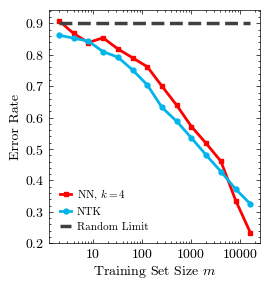

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
from typing import Optional

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    # Define colors as class attributes
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    GREYBLACK = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        
    @staticmethod
    def setup_science_style():
        """Set up consistent science styling with proper log-scale ticks."""
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (2.8, 3.0),
            'figure.dpi': 100,
            
            # Font settings
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            
            # Axis settings
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            
            # Tick settings
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            
            # Grid settings
            'grid.linewidth': 0.5,
            
            # Line settings
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            
            # Legend settings
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def configure_log_axes(self, ax):
        """Configure axes for proper log scale appearance."""
        ax.set_xscale('log')
        ax.minorticks_on()
        
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(mpl.ticker.ScalarFormatter())
            axis.set_tick_params(which='both', direction='in')

def create_plot():
    # Initialize plotter
    plotter = SciencePlotter()
    
    # Create figure and axis
    fig, ax = plt.subplots()
    
    # Your data
    n_train = np.array([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]) #32768
    
    # Example error rates (replace these with your actual data)
    ntk_error = np.array([0.8626999855041504, 0.8531000018119812, 0.8436000347137451, 0.8101999759674072, 0.7928000092506409, 0.7519999742507935, 0.704200029373169, 0.6323000192642212, 0.5881999731063843, 0.5351999998092651, 0.4805999994277954, 0.42840003967285156, 0.37220001220703125, 0.3249000310897827])
    nn_error = np.array([0.909, 0.868, 0.8392, 0.8542, 0.819, 0.7906, 0.7622, 0.7001, 0.6391, 0.5715, 0.5178, 0.4608, 0.33599999999999997, 0.23340000000000005]) #0.14670000000000005
    random_error = np.array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]) #0.9
    
    # Define styles
    nn_style = PlotStyle(
        color=plotter.RED,
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=3.0,
        label=r"NN, $k=4$"
    )
    
    ntk_style = PlotStyle(
        color=plotter.BLUE,
        linestyle='-',
        linewidth=2.0,
        marker='o',
        markersize=3.5,
        label="NTK"
    )
    
    random_style = PlotStyle(
        color=plotter.GREYBLACK,
        linestyle='--',
        linewidth=2.5,
        marker='',
        markersize=2.5,
        label="Random Limit"
    )
    
    # Plot each curve
    ax.plot(n_train, nn_error,
            color=nn_style.color,
            linestyle=nn_style.linestyle,
            linewidth=nn_style.linewidth,
            marker=nn_style.marker,
            markersize=nn_style.markersize,
            label=nn_style.label)
            
    ax.plot(n_train, ntk_error,
            color=ntk_style.color,
            linestyle=ntk_style.linestyle,
            linewidth=ntk_style.linewidth,
            marker=ntk_style.marker,
            markersize=ntk_style.markersize,
            label=ntk_style.label)
            
    ax.plot(n_train, random_error,
            color=random_style.color,
            linestyle=random_style.linestyle,
            linewidth=random_style.linewidth,
            marker=random_style.marker,
            markersize=random_style.markersize,
            label=random_style.label)
    
    # Configure axes
    plotter.configure_log_axes(ax)
    
    # Set labels
    ax.set_xlabel(r'Training Set Size $m$', labelpad=2)
    ax.set_ylabel(r'Error Rate', labelpad=2)
    
    # Add legend
    ax.legend(frameon=False,
             loc='lower left',
             fontsize=8,
             handlelength=1.0,
             handletextpad=0.5)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

if __name__ == "__main__":
    # Create the plot
    fig = create_plot()
    
    # Save plot as both PNG and SVG
    fig.savefig('training_curves.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    fig.savefig('training_curves3.svg',
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    # Show the plot
    plt.show()

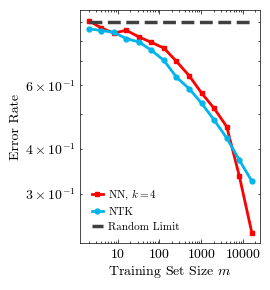

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
from typing import Optional

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    # Define colors as class attributes
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    GREYBLACK = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        
    @staticmethod
    def setup_science_style():
        """Set up consistent science styling with proper log-scale ticks."""
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (3.3, 2.5),  # Changed to match first code
            'figure.dpi': 100,
            
            # Font settings
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            
            # Axis settings
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            
            # Tick settings
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            
            # Grid settings
            'grid.linewidth': 0.5,
            
            # Line settings
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            
            # Legend settings
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def configure_log_axes(self, ax):
        """Configure axes with log scales and decimal notation."""
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.minorticks_on()

        # Configure both axes to use decimal notation
        formatter = mpl.ticker.ScalarFormatter()
        formatter.set_scientific(False)
        
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(formatter)
            axis.set_major_locator(mpl.ticker.LogLocator(numticks=15))
            axis.set_minor_locator(mpl.ticker.LogLocator(subs=np.arange(2, 10), numticks=15))
            axis.set_tick_params(which='both', direction='in')

def create_plot():
    # Initialize plotter
    plotter = SciencePlotter()
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(2.8, 3.0))  # Match the override size from first code
    
    # Your data
    n_train = np.array([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384])
    
    # Example error rates
    ntk_error = np.array([0.8626999855041504, 0.8531000018119812, 0.8436000347137451, 0.8101999759674072, 0.7928000092506409, 0.7519999742507935, 0.704200029373169, 0.6323000192642212, 0.5881999731063843, 0.5351999998092651, 0.4805999994277954, 0.42840003967285156, 0.37220001220703125, 0.3249000310897827])
    nn_error = np.array([0.909, 0.868, 0.8392, 0.8542, 0.819, 0.7906, 0.7622, 0.7001, 0.6391, 0.5715, 0.5178, 0.4608, 0.33599999999999997, 0.23340000000000005])
    random_error = np.array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])
    
    # Define styles to match first code
    nn_style = PlotStyle(
        color=plotter.RED,
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=3.0,
        label=r"NN, $k=4$"
    )
    
    ntk_style = PlotStyle(
        color=plotter.BLUE,
        linestyle='-',
        linewidth=2.0,
        marker='o',
        markersize=3.5,
        label="NTK"
    )
    
    random_style = PlotStyle(
        color=plotter.GREYBLACK,
        linestyle='--',
        linewidth=2.5,
        marker='',
        markersize=2.5,
        label="Random Limit"
    )
    
    # Plot each curve
    ax.plot(n_train, nn_error,
            color=nn_style.color,
            linestyle=nn_style.linestyle,
            linewidth=nn_style.linewidth,
            marker=nn_style.marker,
            markersize=nn_style.markersize,
            label=nn_style.label)
            
    ax.plot(n_train, ntk_error,
            color=ntk_style.color,
            linestyle=ntk_style.linestyle,
            linewidth=ntk_style.linewidth,
            marker=ntk_style.marker,
            markersize=ntk_style.markersize,
            label=ntk_style.label)
            
    ax.plot(n_train, random_error,
            color=random_style.color,
            linestyle=random_style.linestyle,
            linewidth=random_style.linewidth,
            marker=random_style.marker,
            markersize=random_style.markersize,
            label=random_style.label)
    
    # Configure axes
    plotter.configure_log_axes(ax)
    
    # Set labels
    ax.set_xlabel(r'Training Set Size $m$', labelpad=2)
    ax.set_ylabel(r'Error Rate', labelpad=2)
    
    # Add legend with exact same styling as first code
    ax.legend(frameon=False,
             loc='lower left',
             fontsize=8,
             handlelength=1.0,
             handletextpad=0.5)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

if __name__ == "__main__":
    # Create the plot
    fig = create_plot()
    
    # Save plot as both PNG and SVG with identical settings
    fig.savefig('training_curves.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    fig.savefig('training_curves3.svg',
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    # Show the plot
    plt.show()

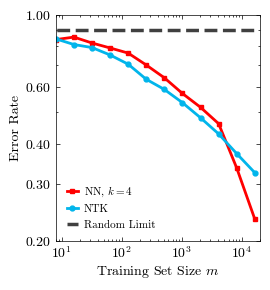

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
from typing import Optional

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    GREYBLACK = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        
    @staticmethod
    def setup_science_style():
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (2.8, 3.0),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def format_x_ticks(self, x, pos):
        """Format x-axis ticks in scientific notation"""
        if x == 0:
            return '0'
        exponent = int(np.log10(x))
        if abs(x - 10**exponent) < 1e-10:
            return f'$10^{{{exponent}}}$'
        return ''  # Hide intermediate ticks

    def format_y_ticks(self, y, pos):
        """Format y-axis ticks with specific values"""
        special_values = {
            1.0: '1.00',
            0.6: '0.60',
            0.4: '0.40',
            0.3: '0.30',
            0.2: '0.20'
        }
        
        # Round to 2 decimal places for comparison
        y_rounded = round(y, 2)
        
        # Check if it's a special value
        for val, label in special_values.items():
            if abs(y_rounded - val) < 1e-10:
                return f'${label}$'
                
        return ''  # Hide other ticks

    def configure_axes(self, ax):
        """Configure axes with different formatting for x and y axes"""
        # Set log scales
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.minorticks_on()
        
        # Configure x-axis
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_x_ticks))
        ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
        ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)))
        
        # Configure y-axis
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_y_ticks))
        major_ticks = [0.2, 0.3, 0.4, 0.6, 1.0]
        ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(major_ticks))
        
        # Set tick parameters
        ax.tick_params(which='both', direction='in')

def create_plot():
    # Initialize plotter
    plotter = SciencePlotter()
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(2.8, 3.0))
    
    # Data
    n_train = np.array([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384])
    ntk_error = np.array([0.8626999855041504, 0.8531000018119812, 0.8436000347137451, 0.8101999759674072, 0.7928000092506409, 0.7519999742507935, 0.704200029373169, 0.6323000192642212, 0.5881999731063843, 0.5351999998092651, 0.4805999994277954, 0.42840003967285156, 0.37220001220703125, 0.3249000310897827])
    nn_error = np.array([0.909, 0.868, 0.8392, 0.8542, 0.819, 0.7906, 0.7622, 0.7001, 0.6391, 0.5715, 0.5178, 0.4608, 0.33599999999999997, 0.23340000000000005])
    random_error = np.array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])
    
    # Styles
    nn_style = PlotStyle(
        color=plotter.RED,
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=3.0,
        label=r"NN, $k=4$"
    )
    
    ntk_style = PlotStyle(
        color=plotter.BLUE,
        linestyle='-',
        linewidth=2.0,
        marker='o',
        markersize=3.5,
        label="NTK"
    )
    
    random_style = PlotStyle(
        color=plotter.GREYBLACK,
        linestyle='--',
        linewidth=2.5,
        label="Random Limit"
    )
    
    # Plot curves
    ax.plot(n_train, nn_error,
            color=nn_style.color,
            linestyle=nn_style.linestyle,
            linewidth=nn_style.linewidth,
            marker=nn_style.marker,
            markersize=nn_style.markersize,
            label=nn_style.label)
            
    ax.plot(n_train, ntk_error,
            color=ntk_style.color,
            linestyle=ntk_style.linestyle,
            linewidth=ntk_style.linewidth,
            marker=ntk_style.marker,
            markersize=ntk_style.markersize,
            label=ntk_style.label)
            
    ax.plot(n_train, random_error,
            color=random_style.color,
            linestyle=random_style.linestyle,
            linewidth=random_style.linewidth,
            label=random_style.label)
    
    # Configure axes
    plotter.configure_axes(ax)
    
    # Set labels
    ax.set_xlabel(r'Training Set Size $m$', labelpad=2)
    ax.set_ylabel(r'Error Rate', labelpad=2)
    
    # Set axis limits
    ax.set_xlim(8, 20000)
    ax.set_ylim(0.2, 1.0)
    
    # Add legend
    ax.legend(frameon=False,
             loc='lower left',
             fontsize=8,
             handlelength=1.0,
             handletextpad=0.5)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

if __name__ == "__main__":
    fig = create_plot()
    
    fig.savefig('training_curves4.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    fig.savefig('training_curves3.svg',
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    plt.show()

In [ ]:
####

Loaded 866 NN results and 2346 NTK results
Loaded 827 NN results and 2484 NTK results


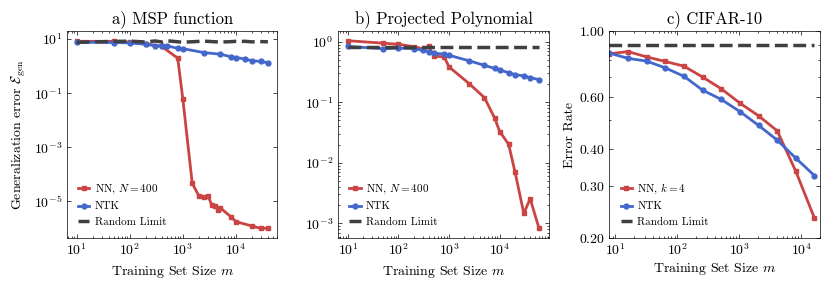

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Union

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    # Define colors as class attributes
    PURPLE = '#8710FF'
    BLUE = '#4467cb'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#cb4444'
    GREYBLACK = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        
    @staticmethod
    def setup_science_style():
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def format_x_ticks(self, x, pos):
        """Format x-axis ticks in scientific notation"""
        if x == 0:
            return '0'
        exponent = int(np.log10(x))
        if abs(x - 10**exponent) < 1e-10:
            return f'$10^{{{exponent}}}$'
        return ''

    def format_y_ticks(self, y, pos):
        """Format y-axis ticks with specific values"""
        special_values = {
            1.0: '1.00',
            0.6: '0.60',
            0.4: '0.40',
            0.3: '0.30',
            0.2: '0.20'
        }
        y_rounded = round(y, 2)
        for val, label in special_values.items():
            if abs(y_rounded - val) < 1e-10:
                return f'${label}$'
        return ''

def plot_results(ax, results_data, nn_config, kernel_config, nn_styles, kernel_styles, plotter):
    # Plot NN results
    for depth in nn_config['depths']:
        for width in nn_config['widths']:
            style = nn_styles.get(width)
            
            for lr in nn_config['learning_rates']:
                results = results_data.filter_results(
                    'nn', depth=depth, hidden_size=width, learning_rate=lr
                )
                if results:
                    sorted_results = sorted(results, key=lambda x: x['n_train'])
                    train_sizes = [r['n_train'] for r in sorted_results]
                    errors = [r['test_error'] for r in sorted_results]
                    
                    ax.plot(train_sizes, errors, 
                           color=style.color,
                           linestyle=style.linestyle,
                           linewidth=style.linewidth,
                           marker=style.marker,
                           markersize=style.markersize,
                           alpha=style.alpha,
                           label=style.label)
    
    # Plot kernel results
    for mode in ['ntk', 'random_limit']:
        for depth in kernel_config['depths']:
            for width in kernel_config['widths']:
                style = kernel_styles.get(mode, {}).get(width)
                if not style:
                    continue
                    
                results = [r for r in results_data.filter_results('kernel', depth=depth, hidden_size=width)
                          if r.get('training_mode') == mode]
                
                if results:
                    sorted_results = sorted(results, key=lambda x: x['n_train'])
                    train_sizes = [r['n_train'] for r in sorted_results]
                    errors = [r['test_error'] for r in sorted_results]
                    
                    ax.plot(train_sizes, errors,
                           color=style.color,
                           linestyle=style.linestyle,
                           linewidth=style.linewidth,
                           marker=style.marker,
                           markersize=style.markersize,
                           alpha=style.alpha,
                           label=style.label)

def create_combined_plot():
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8.4, 3.0))  # 2.8 * 3 = 8.4 for width
    plotter = SciencePlotter()

    # Styles for plots 1 and 2
    nn_styles = {
        400: PlotStyle(
            color=plotter.RED,
            linestyle='-',
            linewidth=2.0,
            marker='s',
            markersize=3.0,
            label=r"NN, $N=400$"
        )
    }
    kernel_styles = {
        'ntk': {
            8000: PlotStyle(
                color=plotter.BLUE,
                linestyle='-',
                linewidth=2.0,
                marker='o',
                markersize=3.5,
                label="NTK"
            )
        },
        'random_limit': {
           8000: PlotStyle(
               color=plotter.GREYBLACK,
               linestyle='dashed',
               linewidth=2.5,
               marker='',
               markersize=2.5,
               label="Random Limit"
           )
        }
    }

    # Plot 1 configuration and data
    nn_config1 = {
        'depths': [4],
        'widths': [400],
        'learning_rates': [0.05]
    }
    kernel_config1 = {
        'depths': [4],
        'widths': [8000]
    }
    nn_dir1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_0701_mup_lr005"
    ntk_path1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_1812_spectral/final_results_20241219_015151.json"
    results_data1 = ResultsLoader.load_results(nn_dir1, ntk_path1)

    # Plot curves for first subplot
    plot_results(ax1, results_data1, nn_config1, kernel_config1, nn_styles, kernel_styles, plotter)
    ax1.set_title('a) MSP function')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r'Training Set Size $m$')
    ax1.set_ylabel(r'Generalization error $\mathcal{E}_{\mathrm{gen}}$')
    ax1.legend(frameon=False, loc='lower left', fontsize=8)

    # Plot 2 configuration and data
    nn_config2 = {
        'depths': [4],
        'widths': [400],
        'learning_rates': [0.001]
    }
    kernel_config2 = {
        'depths': [4],
        'widths': [8000]
    }
    nn_dir2 = "/mnt/users/goringn/NNs_vs_Kernels/low_dim_poly/results/low_dim_poly_NN_2812_mup_lr0001"
    ntk_path2 = "/mnt/users/goringn/NNs_vs_Kernels/low_dim_poly/results/kernel_final.json"
    results_data2 = ResultsLoader.load_results(nn_dir2, ntk_path2)

    # Plot curves for second subplot
    plot_results(ax2, results_data2, nn_config2, kernel_config2, nn_styles, kernel_styles, plotter)
    ax2.set_title('b) Projected Polynomial')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel(r'Training Set Size $m$')
    ax2.legend(frameon=False, loc='lower left', fontsize=8)

    # Plot 3 - Direct data plotting
    n_train = np.array([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384])
    ntk_error = np.array([0.8626999855041504, 0.8531000018119812, 0.8436000347137451, 0.8101999759674072, 
                         0.7928000092506409, 0.7519999742507935, 0.704200029373169, 0.6323000192642212, 
                         0.5881999731063843, 0.5351999998092651, 0.4805999994277954, 0.42840003967285156, 
                         0.37220001220703125, 0.3249000310897827])
    nn_error = np.array([0.909, 0.868, 0.8392, 0.8542, 0.819, 0.7906, 0.7622, 0.7001, 0.6391, 
                        0.5715, 0.5178, 0.4608, 0.33599999999999997, 0.23340000000000005])
    random_error = np.array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])

    # Plot the third set of curves
    ax3.plot(n_train, nn_error,
            color=plotter.RED,
            linestyle='-',
            linewidth=2.0,
            marker='s',
            markersize=3.0,
            label=r"NN, $k=4$")
            
    ax3.plot(n_train, ntk_error,
            color=plotter.BLUE,
            linestyle='-',
            linewidth=2.0,
            marker='o',
            markersize=3.5,
            label="NTK")
            
    ax3.plot(n_train, random_error,
            color=plotter.GREYBLACK,
            linestyle='--',
            linewidth=2.5,
            label="Random Limit")

    # Configure third subplot axes
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(plotter.format_x_ticks))
    ax3.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
    ax3.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)))
    ax3.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(plotter.format_y_ticks))
    major_ticks = [0.2, 0.3, 0.4, 0.6, 1.0]
    ax3.yaxis.set_major_locator(mpl.ticker.FixedLocator(major_ticks))
    ax3.set_xlabel(r'Training Set Size $m$', labelpad=2)
    ax3.set_ylabel(r'Error Rate', labelpad=2)
    ax3.set_xlim(8, 20000)
    ax3.set_ylim(0.2, 1.0)
    ax3.legend(frameon=False, loc='lower left', fontsize=8, handlelength=1.0, handletextpad=0.5)
    ax3.set_title('c) CIFAR-10')

    # Adjust layout
    plt.tight_layout()
    
    return fig

# Create and save the plot
fig = create_combined_plot()

# Save as PNG and SVG
fig.savefig('combined_training_curves.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white',
            edgecolor='black')

fig.savefig('combined_training_curves.svg',
            bbox_inches='tight',
            facecolor='white',
            edgecolor='black')

plt.show()